In [18]:
import numpy as np
import pandas as pd
import os
import shutil
import logging 
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt

from data_process import get_dataset_splits
from utils.evaluation_utils import load_data_from_file, write_results_to_file

In [2]:
import tensorflow as tf
print(tf.__version__)

2024-03-20 13:12:43.670484: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-20 13:12:43.714968: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 13:12:44.497955: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1


In [3]:
from tensorflow.keras import *
#打印时间分割线
@tf.function
def printbar():
    ts = tf.timestamp()
    today_ts = ts%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8,end = "")
    tf.print(timestring)

将所有代码转化为单线程，而非调用函数

# Data processing

In [4]:
dataset = load_data_from_file("results/tf2_test_dataset_with_substitute_confounders.txt")
# 数据类型转换
for key in dataset.keys():
    if key!='sequence_length':
        dataset[key] = dataset[key].astype(np.float32)
    print(key)
    print(dataset[key].shape)
    print(dataset[key].dtype)

previous_covariates
(3000, 160, 25)
float32
previous_treatments
(3000, 160, 3)
float32
covariates
(3000, 161, 25)
float32
treatments
(3000, 161, 3)
float32
sequence_length
(3000,)
int64
outcomes
(3000, 161, 1)
float32
predicted_confounders
(3000, 161, 1)
float32


In [6]:
shuffle_split = ShuffleSplit(n_splits=1, test_size=0.1, random_state=10)
train_index, test_index = next(shuffle_split.split(dataset['covariates'][:, :, 0]))
shuffle_split = ShuffleSplit(n_splits=1, test_size=0.11, random_state=10)
train_index, val_index = next(shuffle_split.split(dataset['covariates'][train_index, :, 0]))
dataset_map = get_dataset_splits(dataset, train_index, val_index, test_index, use_predicted_confounders=True)

# RMSN port

train_rmsn → rnn_fit → train (RNNModel-->training:get_training_graph-->validation:get_prediction_graph) → model_rnn

## train_rmsn

In [7]:
# def train_rmsn(dataset_map, model_name, b_use_predicted_confounders):###########################
# model_name = 'tf2_try'
# MODEL_ROOT = os.path.join('results', model_name)
MODEL_ROOT = 'results/rmsn_tf2_test_use_confounders_True'

# if not os.path.exists(MODEL_ROOT):
#     os.mkdir(MODEL_ROOT)
#     print("Directory ", MODEL_ROOT, " Created ")
# else:
#     # Need to delete previously saved model.
#     shutil.rmtree(MODEL_ROOT)
#     os.mkdir(MODEL_ROOT)
#     print("Directory ", MODEL_ROOT, " Created ")

# rnn_fit参数设置
networks_to_train='propensity_networks'
# networks_to_train='encoder'
b_use_predicted_confounders=True

    # rnn_fit(dataset_map=dataset_map, networks_to_train='propensity_networks', MODEL_ROOT=MODEL_ROOT,
    #         b_use_predicted_confounders=b_use_predicted_confounders)

#     propensity_generation(dataset_map=dataset_map, MODEL_ROOT=MODEL_ROOT,
#                           b_use_predicted_confounders=b_use_predicted_confounders)

#     rnn_fit(networks_to_train='encoder', dataset_map=dataset_map, MODEL_ROOT=MODEL_ROOT,
#             b_use_predicted_confounders=b_use_predicted_confounders)

#     rmsn_mse = rnn_test(dataset_map=dataset_map, MODEL_ROOT=MODEL_ROOT,
#                         b_use_predicted_confounders=b_use_predicted_confounders)

#     rmse = np.sqrt(np.mean(rmsn_mse)) * 100
    # return rmse


## rnn_fit

### 1.1 基础参数设置

In [7]:
specifications = {
     'rnn_propensity_weighted': (0.1, 4, 100, 64, 0.01, 1.0),
     'treatment_rnn_action_inputs_only': (0.1, 3, 100, 128, 0.01, 2.0),
     'treatment_rnn': (0.1, 4, 100, 64, 0.01, 1.0),}
# #####################################################################################
# def rnn_fit(dataset_map, networks_to_train, MODEL_ROOT, b_use_predicted_confounders,
#             b_use_oracle_confounders=False, b_remove_x1=False):
    
# Get the correct networks to train
if networks_to_train == "propensity_networks":
    logging.info("Training propensity networks")
    net_names = ['treatment_rnn_action_inputs_only']
    # net_names = ['treatment_rnn']

elif networks_to_train == "encoder":
    logging.info("Training R-MSN encoder")
    net_names = ["rnn_propensity_weighted"]

elif networks_to_train == "user_defined":
    logging.info("Training user defined network")
    raise NotImplementedError("Specify network to use!")

else:
    raise ValueError("Unrecognised network type")

    logging.info("Running hyperparameter optimisation")

# Experiment name
expt_name = "treatment_effects"

# Possible networks to use along with their activation functions
# change hidden layer of rnn_propensity_weighted to tanh
activation_map = {'rnn_propensity_weighted': ("tanh", 'linear'),
                  'rnn_propensity_weighted_logistic': ("elu", 'linear'),
                  'rnn_model': ("elu", 'linear'),
                  'treatment_rnn': ("tanh", 'sigmoid'),
                  'treatment_rnn_action_inputs_only': ("tanh", 'sigmoid')
                  }

    
# Start Running hyperparam opt
opt_params = {}
# for net_name in net_names:
net_name = net_names[0]
# Re-run hyperparameter optimisation if parameters are not specified, otherwise train with defined params（如果需要超参优化则跑3次，否则跑一次就行）
max_hyperparam_runs = 3 if net_name not in specifications else 1

# Pull datasets
b_predict_actions = "treatment_rnn" in net_name
use_truncated_bptt = net_name != "rnn_model_bptt" # whether to train with truncated backpropagation through time
b_propensity_weight = "rnn_propensity_weighted" in net_name
b_use_actions_only = "rnn_action_inputs_only" in net_name

### 1.2 gpu设置

In [8]:
# Setup tensorflow
# 检测 GPU 设备
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # set TensorFlow to use all GPU
        tf.config.set_visible_devices(gpus, 'GPU')
        for gpu in gpus:
            # set GPU memery growth
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Using GPU with memory growth")
    except RuntimeError as e:
        # Changing device settings after the program is running may cause errors
        print(e)
else:
    # if no GPU，using CPU
    print("No GPU found, using CPU")

Using GPU with memory growth


In [9]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

### 1.3 模型参数配置

In [9]:
# Start hyperparamter optimisation
hyperparam_count = 0
# 删掉超参数优化（随机选取超参数）部分
spec = specifications[net_name]
logging.info("Using specifications for {}: {}".format(net_name, spec))
dropout_rate = spec[0]
memory_multiplier = spec[1]
num_epochs = spec[2]
minibatch_size = spec[3]
learning_rate = spec[4]
max_norm = spec[5]
hidden_activation, output_activation = activation_map[net_name]

model_folder = os.path.join(MODEL_ROOT, net_name)
            
# hyperparam_opt = train(net_name, expt_name,
#                       training_processed, validation_processed, test_processed,
#                       dropout_rate, memory_multiplier, num_epochs,
#                       minibatch_size, learning_rate, max_norm,
#                       use_truncated_bptt,
#                       num_features, num_outputs, model_folder,
#                       hidden_activation, output_activation,
#                       config,
#                       "hyperparam opt: {} of {}".format(hyperparam_count,
#                                                         max_hyperparam_runs))

#     hyperparam_count = len(hyperparam_opt.columns)
#     if hyperparam_count >= max_hyperparam_runs:
#         opt_params[net_name] = hyperparam_opt.T
#         break

# logging.info("Done")
# logging.info(hyperparam_opt.T)

# # Flag optimal params
# logging.info(opt_params)

#### 数据处理函数

In [9]:
def get_processed_data(raw_sim_data,
                       b_predict_actions,
                       b_use_actions_only,
                       b_use_predicted_confounders,
                       b_use_oracle_confounders,
                       b_remove_x1,
                       keep_first_point=False):
    """
    Create formatted data to train both propensity networks and seq2seq architecture

    :param raw_sim_data: Data from simulation
    :param scaling_params: means/standard deviations to normalise the data to
    :param b_predict_actions: flag to package data for propensity network to forecast actions
    :param b_use_actions_only:  flag to package data with only action inputs and not covariates
    :param b_predict_censoring: flag to package data to predict censoring locations
    :return: processed data to train specific network
    """
    horizon = 1
    offset = 1

    # Change Continuous values 2 Multiclass values
    treatments = raw_sim_data['treatments']
    continuous_indices = [index for index in range(treatments.shape[2]) if not np.all(np.isin(treatments[:, :, index], [0, 1]))]
    bins = 20
    for index in continuous_indices:
        # 对每个连续值列进行分箱编码
        treatments[:, :, index] = np.digitize(treatments[:, :, index], 
                                                    bins=np.linspace(treatments[:, :, index].min(), treatments[:, :, index].max(), bins+1)[1:-1], 
                                                    right=True)
    
    # Binary application
    
    covariates = raw_sim_data['covariates']
    dataset_outputs = raw_sim_data['outcomes']
    sequence_lengths = raw_sim_data['sequence_length']
    
    if b_use_predicted_confounders:
        predicted_confounders = raw_sim_data['predicted_confounders']

    if b_use_oracle_confounders:
        predicted_confounders = raw_sim_data['confounders']

    num_treatments = treatments.shape[-1]

    # Parcelling INPUTS
    if b_predict_actions:
        if b_use_actions_only:
            inputs = treatments
            inputs = inputs[:, :-offset, :]

            actions = inputs.copy()

        else:
            # Uses current covariate, to remove confounding effects between action and current value
            if (b_use_predicted_confounders):
                print ("Using predicted confounders")
                inputs = np.concatenate([covariates[:, 1:, ], predicted_confounders[:, 1:, ], treatments[:, :-1, ]],
                                        axis=2)
            else:
                inputs = np.concatenate([covariates[:, 1:,], treatments[:, :-1, ]], axis=2)

            actions = inputs[:, :, -num_treatments:].copy()


    else:
        if (b_use_predicted_confounders):
            inputs = np.concatenate([covariates, predicted_confounders, treatments], axis=2)
        else:
            inputs = np.concatenate([covariates, treatments], axis=2)
        
        if not keep_first_point:
            inputs = inputs[:, 1:, :]

        actions = inputs[:, :, -num_treatments:].copy()


    # Parcelling OUTPUTS
    if b_predict_actions:
        outputs = treatments
        outputs = outputs[:, 1:, :]

    else:
        if keep_first_point:
            outputs = dataset_outputs
        else:
            outputs = dataset_outputs[:, 1:, :]


    # Set array alignment
    sequence_lengths = np.array([i - 1 for i in sequence_lengths]) # everything shortens by 1

    # Remove any trajectories that are too short
    inputs = inputs[sequence_lengths > 0, :, :]
    outputs = outputs[sequence_lengths > 0, :, :]
    sequence_lengths = sequence_lengths[sequence_lengths > 0]
    actions = actions[sequence_lengths > 0, :, :]

    # Add active entires
    active_entries = np.zeros(outputs.shape, dtype=np.float32)

    for i in range(sequence_lengths.shape[0]):
        sequence_length = int(sequence_lengths[i])

        if not b_predict_actions:
            for k in range(horizon):
                #include the censoring point too, but ignore future shifts that don't exist
                active_entries[i, :sequence_length-k, k] = 1
        else:
            active_entries[i, :sequence_length, :] = 1

    return {'outputs': outputs,  # already scaled
            'scaled_inputs': inputs,
            'scaled_outputs': outputs,
            'actions': actions,
            'sequence_lengths': sequence_lengths,
            'active_entries': active_entries
            }


def convert_to_tf_dataset(dataset_map, minibatch_size):
    key_map = {'inputs': dataset_map['scaled_inputs'],
               'outputs': dataset_map['scaled_outputs'],
               'active_entries': dataset_map['active_entries'],
               'sequence_lengths': dataset_map['sequence_lengths']}

    if 'propensity_weights' in dataset_map:
        key_map['propensity_weights'] = dataset_map['propensity_weights']

    if 'initial_states' in dataset_map:
        key_map['initial_states'] = dataset_map['initial_states']

    #from_tensor_slices:切片; shuffle:随机打乱; batch:批次组合; prefetch:提前准备（预取）数据
    tf_dataset = tf.data.Dataset.from_tensor_slices(key_map)\
                .shuffle(buffer_size = 1000).batch(minibatch_size) \
                .prefetch(tf.data.experimental.AUTOTUNE)

    return tf_dataset

### 1.4 数据准备

In [11]:
training_data = dataset_map['training_data']
validation_data = dataset_map['validation_data']
test_data = dataset_map['test_data']

 # Extract only relevant trajs and shift data
b_use_oracle_confounders = False; b_remove_x1 = False
training_processed = get_processed_data(training_data, b_predict_actions,
                                             b_use_actions_only, b_use_predicted_confounders,
                                             b_use_oracle_confounders, b_remove_x1)
validation_processed = get_processed_data(validation_data, b_predict_actions,
                                               b_use_actions_only, b_use_predicted_confounders,
                                               b_use_oracle_confounders, b_remove_x1)
test_processed = get_processed_data(test_data, b_predict_actions,
                                         b_use_actions_only, b_use_predicted_confounders,
                                         b_use_oracle_confounders, b_remove_x1)

num_features = training_processed['scaled_inputs'].shape[-1]
num_outputs = training_processed['scaled_outputs'].shape[-1]



In [12]:
# Load propensity weights if they exist
if b_propensity_weight:
    if net_name == 'rnn_propensity_weighted_den_only':
        # use un-stabilised IPTWs generated by propensity networks
        propensity_weights = np.load(os.path.join(MODEL_ROOT, "propensity_scores_den_only.npy"))
    elif net_name == "rnn_propensity_weighted_logistic":
        # Use logistic regression weights
        propensity_weights = np.load(os.path.join(MODEL_ROOT, "propensity_scores.npy"))
        tmp = np.load(os.path.join(MODEL_ROOT, "propensity_scores_logistic.npy"))
        propensity_weights = tmp[:propensity_weights.shape[0], :, :]
    else:
        # use stabilised IPTWs generated by propensity networks
        propensity_weights = np.load(os.path.join(MODEL_ROOT, "propensity_scores.npy"))

    logging.info("Net name = {}. Mean-adjusting!".format(net_name))

    propensity_weights /= propensity_weights.mean()

    training_processed['propensity_weights'] = np.array(propensity_weights, dtype='float32')
    

In [13]:
# transform to tensorflow format
tf_data_train = convert_to_tf_dataset(training_processed, minibatch_size)
tf_data_valid = convert_to_tf_dataset(validation_processed, minibatch_size)
tf_data_test = convert_to_tf_dataset(test_processed, minibatch_size)

In [15]:
tf_data_train

<_PrefetchDataset element_spec={'inputs': TensorSpec(shape=(None, 160, 3), dtype=tf.float32, name=None), 'outputs': TensorSpec(shape=(None, 160, 3), dtype=tf.float32, name=None), 'active_entries': TensorSpec(shape=(None, 160, 3), dtype=tf.float32, name=None), 'sequence_lengths': TensorSpec(shape=(None,), dtype=tf.int64, name=None)}>

## core routine

### def_train修改
1. 去除session会话
2. 各步骤拆分与重构

#### 2.1 参数指定

In [ ]:
# def train(net_name,
#           expt_name,
#           training_dataset, validation_dataset, test_dataset,
#           dropout_rate,
#           memory_multiplier,
#           num_epochs,
#           minibatch_size,
#           learning_rate,
#           max_norm,
#           use_truncated_bptt,
#           num_features,
#           num_outputs,
#           model_folder,
#           hidden_activation,
#           output_activation,
#           tf_config,
#           additonal_info="",
#           b_use_state_initialisation=False,
#           b_use_seq2seq_feedback=False,
#           b_use_seq2seq_training_mode=False,
#           adapter_multiplier=0,
#           b_use_memory_adapter=False,
#           verbose=True):

In [14]:
min_epochs = 1
# hidden_layer_size = int(memory_multiplier * num_features)
hidden_layer_size = 128

b_use_state_initialisation = False
if b_use_state_initialisation:
    full_state_size = int(training_dataset['initial_states'].shape[-1])
    adapter_size = adapter_multiplier * full_state_size
else:
    adapter_size = 0
    
model_parameters = {'net_name': net_name,
                    'experiment_name': expt_name,
                    'training_dataset': tf_data_train,
                    'validation_dataset': tf_data_valid,
                    'test_dataset': tf_data_test,
                    'dropout_rate': dropout_rate,
                    'input_size': num_features,
                    'output_size': num_outputs,
                    'hidden_layer_size': hidden_layer_size,
                    'num_epochs': 10, # for test
                    'minibatch_size': minibatch_size,
                    'learning_rate': learning_rate,
                    'max_norm': max_norm,
                    'model_folder': model_folder,
                    'hidden_activation': hidden_activation,
                    'output_activation': output_activation,
                    'backprop_length': 60,  # backprop over 60 timesteps for truncated backpropagation through time
                    'softmax_size': 1, #not used in this paper, but allows for categorical actions
                    'mc_size': 0,
                    'performance_metric': 'xentropy' if output_activation == 'sigmoid' else 'mse'}

#### 2.2 定义模型

In [15]:
def create_model(params):
    
    # Data params
    #training_data = None if 'training_dataset' not in params else params['training_dataset']
    #validation_data = None if 'validation_dataset' not in params else params['validation_dataset']
    #test_data = None if 'test_dataset' not in params else params['test_dataset']
    input_size = params['input_size']
    output_size = params['output_size']

    # Network params
    net_name = params['net_name']
    softmax_size = params['softmax_size']
    bins = 20
    predict_size = output_size - softmax_size + bins
    dropout_rate = params['dropout_rate']
    hidden_layer_size = params['hidden_layer_size']
    memory_activation_type = params['hidden_activation']
    output_activation_type = params['output_activation']
    #initial_states = None
    # input layer
    inputs = layers.Input(shape=(None,input_size), dtype=tf.float32)
    # define initial states 
    initial_h =layers.Input(shape=(hidden_layer_size,), dtype=tf.float32, name='initial_h')
    initial_c =layers.Input(shape=(hidden_layer_size,), dtype=tf.float32, name='initial_c')

    # LSTM layer
    lstm, state_h, state_c = layers.LSTM(hidden_layer_size, activation=memory_activation_type, 
                       return_sequences=True, return_state=True, dropout=dropout_rate)(inputs, initial_state=[initial_h, initial_c])

    # flattened_lstm = layers.Flatten()(lstm)

    # linear output layer
    logits = layers.Dense(predict_size)(lstm)

    # Softmax（对应多分类任务）
    if softmax_size != 0:
        logits_reshaped = layers.Reshape((-1, predict_size))(logits)
        softmax_outputs, core_outputs = tf.split(logits_reshaped, [bins, predict_size - bins], axis=-1)
        core_activated = layers.Activation(output_activation_type)(core_outputs)
        softmax_activated = layers.Softmax(axis=-1)(softmax_outputs)
        outputs = layers.Concatenate(axis=-1)([softmax_activated, core_activated])
    
    # MC dropout（对应连续任务）
    elif mc_size != 0:
        logits_reshaped = layers.Reshape((-1, output_size))(logits)
        mc_outputs, core_outputs = tf.split(logits_reshaped, [mc_size, output_size - mc_size], axis=-1)
        core_activated = layers.Activation(output_activation_type)(core_outputs)
        mc_activated = layers.Dense(1)(mc_outputs)
        mc_activated = layers.Dropout(dropout_rate)(mc_activated, training=True) # 启用dropout，即使在推断时
        outputs = layers.Concatenate(axis=-1)([mc_activated, core_activated])
    
    else:
        outputs = layers.Activation(output_activation_type)(logits)

    # construct model
    model = models.Model(inputs=[inputs, initial_h, initial_c], outputs=[outputs, state_h, state_c], name=net_name)
    return model

In [16]:
# 创建模型
tf.keras.backend.clear_session()
model = create_model(model_parameters)

model.summary()

Model: "treatment_rnn_action_inputs_only"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, 3)]            0         []                            
                                                                                                  
 initial_h (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 initial_c (InputLayer)      [(None, 128)]                0         []                            
                                                                                                  
 lstm (LSTM)                 [(None, None, 128),          67584     ['input_1[0][0]',             
                              (None, 128),                         

### 2.3 训练模型

#### 自定义损失函数

In [18]:
class CustomLoss(losses.Loss):
    def __init__(self, performance_metric, name="custom_loss"):
        super().__init__(name=name)
        self.performance_metric = performance_metric
        # self.weights = params['weights']
        # self.active_entries = params['active_entries']

    def train_call(self, y_true, y_pred, active_entries, weights):
        if self.performance_metric == "mse":
            loss = tf.reduce_sum(tf.square(y_true - y_pred) * active_entries * weights) \
                   / tf.reduce_sum(active_entries)
        elif self.performance_metric == "xentropy":
            loss = tf.reduce_sum((y_true * -tf.math.log(y_pred + 1e-8) +
                                  (1 - y_true) * -tf.math.log(1 - y_pred + 1e-8))
                                  * active_entries * weights) / tf.reduce_sum(active_entries)
        elif self.performance_metric == "sparse_xentropy":
            scce = losses.SparseCategoricalCrossentropy(from_logits=False)
            loss = scce(y_true, y_pred, sample_weight=active_entries * weights)
        else:
            raise ValueError("Unknown performance metric {}".format(self.performance_metric))
        return loss
    
    def valid_call(self, y_true, y_pred, active_entries):
        if self.performance_metric == "mse":
            loss = tf.reduce_sum(tf.square(y_true - y_pred) * active_entries ) \
                   / tf.reduce_sum(active_entries)
        elif self.performance_metric == "xentropy":
            loss = tf.reduce_sum((y_true * -tf.math.log(y_pred + 1e-8) +
                                  (1 - y_true) * -tf.math.log(1 - y_pred + 1e-8))
                                  * active_entries) / tf.reduce_sum(active_entries)
        elif self.performance_metric == "sparse_xentropy":
            scce = losses.SparseCategoricalCrossentropy(from_logits=False)
            loss = scce(y_true, y_pred)
        else:
            raise ValueError("Unknown performance metric {}".format(self.performance_metric))
        return loss
    
    def get_config(self):
        config = super().get_config()
        config.update({"performance_metric": self.performance_metric})
        return config

#### 训练步骤和验证步骤

In [19]:
optimizer = optimizers.Adam(learning_rate=model_parameters['learning_rate'])
# continuous_loss_func = CustomLoss(performance_metric='mse')
multiclass_loss_func = CustomLoss(performance_metric='sparse_xentropy')
binary_loss_func = CustomLoss(performance_metric='xentropy')

train_loss = metrics.Mean(name='train_loss')
train_metric = metrics.MeanSquaredError(name='train_mse')

valid_loss = metrics.Mean(name='valid_loss')
valid_metric = metrics.MeanSquaredError(name='valid_mse')

mc_size = 1

@tf.function
def train_step(model, inputs, outputs, active_entries, weights):
    if weights is None:
        weights = tf.constant(1.0)
    with tf.GradientTape() as tape:
        
        continuous_outputs, binary_outputs = tf.split(outputs, [mc_size, output_size - mc_size], axis=-1)
        predictions = model(inputs, training=True)
        continuous_preds, binary_preds = tf.split(predictions, [bins, predict_size - bins], axis=-1)
        
        continuous_loss = continuous_loss_func.train_call(continuous_outputs, continuous_predictions, active_entries, weights)
        binary_loss = binary_loss_func.train_call(binary_outputs, binary_predictions, active_entries, weights)
        total_loss = continuous_loss + binary_loss
        
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss.update_state(total_loss)
    train_metric.update_state(continuous_outputs, continuous_preds)
    
@tf.function
def valid_step(model, inputs, outputs, active_entries):
    continuous_outputs, binary_outputs = tf.split(outputs, [mc_size, output_size - mc_size], axis=-1)    
    predictions = model(inputs, training=False)
    continuous_preds, binary_preds = tf.split(predictions, [bins, predict_size - bins], axis=-1)
    
    continuous_loss = continuous_loss_func.valid_call(continuous_outputs, continuous_predictions, active_entries)
    binary_loss = binary_loss_func.valid_call(binary_outputs, binary_predictions, active_entries)
    total_loss = continuous_loss + binary_loss
    valid_loss.update_state(total_loss)
    valid_metric.update_state(continuous_outputs, continuous_preds)

#### 训练模型函数

In [36]:
def train_model(model, ds_train, ds_valid, epochs):
    # optimisation_summary = pd.Series([])
    for epoch in tf.range(1, epochs+1):
        
        for data in ds_train:
            weights = data['propensity_weights'] if 'propensity_weights' in data else None
            train_step(model, data['inputs'], data['outputs'], data['active_entries'], weights)

        for data in ds_valid:
            weights = data['propensity_weights'] if 'propensity_weights' in data else None
            valid_step(model, data['inputs'], data['outputs'], data['active_entries'])
        # optimisation_summary[epoch] = valid_loss

        # 同样的日志和状态重置操作
        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'
        
        if epoch%1 ==0:
            printbar()
            tf.print(tf.strings.format(logs,
            (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))
            tf.print("")
            
        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()

In [20]:
class TrainModule(tf.Module):
    def __init__(self, params, name=None):
        super(TrainModule, self).__init__(name=name)
        with self.name_scope:  #相当于with tf.name_scope("demo_module")
            # self.epochs = params['num_epochs']
            self.epochs = 10
            self.bins = 20
            self.ds_train = params['training_dataset']
            self.ds_valid = params['validation_dataset']
            self.ds_test = params['test_dataset']
            self.optimizer = optimizers.Adam(learning_rate=params['learning_rate'])
            self.output_size = params['output_size']
            self.softmax_size = params['softmax_size']
            self.predict_size = params['output_size'] - params['softmax_size'] + self.bins
            self.hidden_layer_size = params['hidden_layer_size']
            # self.loss_func = CustomLoss(params)
            self.multiclass_loss_func = CustomLoss(performance_metric='sparse_xentropy')
            self.binary_loss_func = CustomLoss(performance_metric='xentropy')

            self.multiclass_train_loss = metrics.Mean(name='multiclass_train_loss')
            self.binary_train_loss = metrics.Mean(name='binary_train_loss')
            self.train_metric = metrics.MeanSquaredError(name='train_mse')

            self.multiclass_valid_loss = metrics.Mean(name='multiclass_valid_loss')
            self.binary_valid_loss = metrics.Mean(name='binary_valid_loss')
            self.valid_metric = metrics.MeanSquaredError(name='valid_mse')
            
    
    @tf.function
    def train_step(self, model, inputs, outputs, active_entries, weights):
        if weights is None:
            weights = tf.constant(1.0)
        with tf.GradientTape() as tape:
            multiclass_outputs, binary_outputs = tf.split(outputs, [self.softmax_size, self.output_size - self.softmax_size], axis=-1)
            batch_size = tf.shape(inputs)[0]
            initial_state = tf.zeros([batch_size, self.hidden_layer_size], dtype=tf.float32)
            predictions,_,_ = model([inputs,initial_state, initial_state], training=True)
            multiclass_preds, binary_preds = tf.split(predictions, [self.bins, self.predict_size - self.bins], axis=-1)
            active_entries1, active_entries2 = tf.split(active_entries, [self.softmax_size, self.output_size - self.softmax_size], axis=-1)
            
            multiclass_loss = self.multiclass_loss_func.train_call(multiclass_outputs, multiclass_preds, active_entries1, weights)
            binary_loss = self.binary_loss_func.train_call(binary_outputs, binary_preds, active_entries2, weights)
            total_loss = multiclass_loss + binary_loss

        gradients = tape.gradient(total_loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # self.train_loss.update_state(total_loss)
        self.multiclass_train_loss.update_state(multiclass_loss)
        self.binary_train_loss.update_state(binary_loss)
        self.train_metric.update_state(binary_outputs, binary_preds)

    @tf.function
    def valid_step(self, model, inputs, outputs, active_entries):
        multiclass_outputs, binary_outputs = tf.split(outputs, [self.softmax_size, self.output_size - self.softmax_size], axis=-1) 
        batch_size = tf.shape(inputs)[0]
        initial_state = tf.zeros([batch_size, self.hidden_layer_size], dtype=tf.float32)
        predictions,_,_ = model([inputs,initial_state, initial_state], training=False)
        multiclass_preds, binary_preds = tf.split(predictions, [self.bins, self.predict_size - self.bins], axis=-1)
        active_entries1, active_entries2 = tf.split(active_entries, [self.softmax_size, self.output_size - self.softmax_size], axis=-1)

        multiclass_loss = self.multiclass_loss_func.valid_call(multiclass_outputs, multiclass_preds, active_entries1)
        binary_loss = self.binary_loss_func.valid_call(binary_outputs, binary_preds, active_entries2)
        total_loss = multiclass_loss + binary_loss
        
        self.multiclass_valid_loss.update_state(multiclass_loss)
        self.binary_valid_loss.update_state(binary_loss)
        self.valid_metric.update_state(binary_outputs, binary_preds)
    
    def train_model(self, model):
        # optimisation_summary = pd.Series([])
        for epoch in tf.range(1, self.epochs+1):

            for data in self.ds_train:
                weights = data['propensity_weights'] if 'propensity_weights' in data else None
                self.train_step(model, data['inputs'], data['outputs'], data['active_entries'], weights)

            for data in self.ds_valid:
                weights = data['propensity_weights'] if 'propensity_weights' in data else None
                self.valid_step(model, data['inputs'], data['outputs'], data['active_entries'])
            # optimisation_summary[epoch] = valid_loss

            # 同样的日志和状态重置操作
            logs = 'Epoch={},Multiclass Loss:{},Binary Loss:{},Accuracy:{},Multiclass Valid Loss:{}, Binary Valid Loss:{},Valid Accuracy:{}'

            if epoch%1 ==0:
                printbar()
                tf.print(tf.strings.format(logs,
                (epoch,self.multiclass_train_loss.result(),self.binary_train_loss.result(),
                 self.train_metric.result(),self.multiclass_valid_loss.result(),self.binary_valid_loss.result(),
                 self.valid_metric.result())))
                tf.print("")

            self.multiclass_train_loss.reset_states()
            self.binary_train_loss.reset_states()
            self.multiclass_valid_loss.reset_states()
            self.binary_valid_loss.reset_states()
            self.train_metric.reset_states()
            self.valid_metric.reset_states()

In [ ]:
Train = TrainModule(model_parameters)
Train.train_model(model)

In [32]:
net_names = ['model1','model2']
for name in net_names:
    tf.keras.backend.clear_session()
    model = create_model(model_parameters, name)
    # train_model(model, tf_data_train, tf_data_valid, 10)
    Train = TrainModule(model_parameters)
    Train.train_model(model)

================================================================================12:15:12
Epoch=1,Loss:-1.04218924,Accuracy:0.315503478,Valid Loss:-1.6271013,Valid Accuracy:0.256319433

================================================================================12:15:13
Epoch=2,Loss:-1.8213017,Accuracy:0.25058189,Valid Loss:-1.92948687,Valid Accuracy:0.243127644

================================================================================12:15:14
Epoch=3,Loss:-1.99545646,Accuracy:0.245146066,Valid Loss:-2.00789499,Valid Accuracy:0.237991899

================================================================================12:15:14
Epoch=4,Loss:-2.0445447,Accuracy:0.242646903,Valid Loss:-2.07682967,Valid Accuracy:0.236074388

================================================================================12:15:15
Epoch=5,Loss:-2.07054353,Accuracy:0.241571859,Valid Loss:-2.07036352,Valid Accuracy:0.23433511

===========================================================================

### 2.4 保存和加载模型

In [24]:
path = 'results/tf2_try/treatment_rnn'
model.save(path, save_format = 'tf')
print('export saved model.')

INFO:tensorflow:Assets written to: results/tf2_try/treatment_rnn/assets


INFO:tensorflow:Assets written to: results/tf2_try/treatment_rnn/assets


export saved model.


In [45]:
model_loaded = models.load_model(path, compile=False)

### 2.5 使用模型

In [38]:
# 自定义模型评估函数
def evaluate_model(model, ds_test):
    total_loss = 0
    total_metric = 0
    num_batches = 0

    # 遍历数据集中的每个批次
    for data in ds_test:
        valid_step(model, data['inputs'], data['outputs'], data['active_entries'])
        total_loss += valid_loss.result().numpy()
        total_metric += valid_metric.result().numpy()
        num_batches += 1

        # 重置状态
        valid_loss.reset_states()
        valid_metric.reset_states()

    # 计算整个数据集的平均损失和指标
    avg_loss = total_loss / num_batches
    avg_metric = total_metric / num_batches
    return avg_loss, avg_metric

In [46]:
loss, accuracy = evaluate_model(model, tf_data_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")
input_data_for_prediction = tf_data_test.map(lambda x: x['inputs'])
predictions = model_loaded.predict(input_data_for_prediction)

Test Loss: -2.254194164276123, Test Accuracy: 0.22184113562107086
5/5 [==============================] - 0s 7ms/step


In [47]:
predictions.shape

(300, 160, 3)

## Propensitry Generation
def propensity_generation(dataset_map, MODEL_ROOT, b_use_predicted_confounders, b_use_all_data=False,
                          b_use_oracle_confounders=False, b_remove_x1=False):

In [11]:
path_actions = os.path.join(MODEL_ROOT, "treatment_rnn_action_inputs_only/treatment_rnn_action_inputs_only_0.1_78_100_128_0.005_2.0_60_optimal")
model_actions = models.load_model(path_actions, compile=False)

path_treats = os.path.join(MODEL_ROOT, "treatment_rnn/treatment_rnn_0.1_145_100_64_0.005_1.0_60_optimal")
model_treats = models.load_model(path_treats, compile=False)

2024-03-20 13:15:56.564629: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:42:00.0, compute capability: 8.9
2024-03-20 13:15:56.565474: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22288 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:43:00.0, compute capability: 8.9
2024-03-20 13:15:56.566205: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22288 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:83:00.0, compute capability: 8.9
2024-03-20 13:15:56.566838: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22288 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 4090

In [79]:
import rmsn.libs.rmsn_model as rmsn_model

In [14]:
# 参数设置
# action_inputs_only = rmsn_model.load_optimal_parameters(net_name='treatment_rnn_action_inputs_only', MODEL_ROOT=MODEL_ROOT)
# action_w_trajectory_inputs = rmsn_model.load_optimal_parameters(net_name='treatment_rnn', MODEL_ROOT=MODEL_ROOT)

# Generate propensity weights for validation data as well - used for MSM which is calibrated on train + valid data
b_with_validation = False
# Generate non-stabilised IPTWs (default false)
b_denominator_only = False
b_use_predicted_confounders = False
b_use_all_data=False
b_use_oracle_confounders=False
b_remove_x1=False

# Config + activation functions
activation_map = {'rnn_propensity_weighted': ("elu", 'linear'),
                  'rnn_model': ("elu", 'linear'),
                  'rnn_model_bptt': ("elu", 'linear'),
                  'treatment_rnn': ("tanh", 'sigmoid'),
                  'treatment_rnn_action_inputs_only': ("tanh", 'sigmoid'),
                  'treatment_rnn_softmax': ("tanh", 'sigmoid'),
                  'treatment_rnn_action_inputs_only_softmax': ("tanh", 'sigmoid'),
                  }

# configs = {'action_num': action_inputs_only,
#            'action_den': action_w_trajectory_inputs}

In [15]:
if b_use_all_data:
    training_data = dataset_map
    validation_data = dataset_map
    test_data = None
else:
    training_data = dataset_map['training_data']
    validation_data = dataset_map['validation_data']
    test_data = dataset_map['test_data']
    
if b_with_validation:
    for k in training_data:
        training_data[k] = np.concatenate([training_data[k], validation_data[k]])

In [16]:
def convert_to_tf_dataset_predict(dataset_map, minibatch_size):
    key_map = {'inputs': dataset_map['scaled_inputs'],
               'outputs': dataset_map['scaled_outputs'],
               'active_entries': dataset_map['active_entries'],
               'sequence_lengths': dataset_map['sequence_lengths']}

    if 'propensity_weights' in dataset_map:
        key_map['propensity_weights'] = dataset_map['propensity_weights']

    if 'initial_states' in dataset_map:
        key_map['initial_states'] = dataset_map['initial_states']

    #from_tensor_slices:切片; shuffle:随机打乱; batch:批次组合; prefetch:提前准备（预取）数据
    tf_dataset = tf.data.Dataset.from_tensor_slices(key_map)\
                .batch(minibatch_size) \
                .prefetch(tf.data.experimental.AUTOTUNE)

    return tf_dataset

In [17]:
def model_predict(model, dataset, hidden_layer_size, mc_sampling=False):
    # Initialize lists to store final statistics for all chunks
    Predictions = []
    logs = 'Predicting ' + model.name
    if mc_sampling:
        pred_times = 10
    else:
        pred_times = 1

    for _ in range(pred_times):
        predictions = []
        for data_chunk in tqdm(dataset, desc=logs):
            batch_size = tf.shape(data_chunk['inputs'])[0]
            initial_state = tf.zeros([batch_size, hidden_layer_size], dtype=tf.float32)
            # Predict the current chunk multiple times
            chunk_prediction, _, _ = model.predict([data_chunk['inputs'], initial_state, initial_state], verbose=0)
            # print(prediction.shape)
                # chunk_predictions.append(prediction)

            # Convert list of predictions to a numpy array for statistical computation
            # chunk_predictions = np.array(chunk_predictions)
            predictions.extend(chunk_prediction)
        
        if mc_sampling:
            Predictions.append(predictions)
    
    if mc_sampling:
        return np.stack(Predictions,axis=0)
    else:
        return np.array(predictions)

In [21]:
# Functions
def get_predictions(model, dataset, hidden_layer_size):
    # Pull datasets
    net_name = model.name
    b_predict_actions = "treatment_rnn" in net_name
    b_use_actions_only = "rnn_action_inputs_only" in net_name
    b_use_predicted_confounders = True
    softmax_size = 1
    num_bins = 20
    minibatch_size = 128

    # Extract only relevant trajs and shift data
    training_processed = get_processed_data(training_data, b_predict_actions, b_use_actions_only,
                                                 b_use_predicted_confounders, b_use_oracle_confounders, b_remove_x1)
    validation_processed = get_processed_data(validation_data, b_predict_actions,
                                                   b_use_actions_only,
                                                   b_use_predicted_confounders, b_use_oracle_confounders, b_remove_x1)
    # rango added 23.10.24
    # if b_with_test:
    #     test_processed = core.get_processed_data(test_data, b_predict_actions, b_use_actions_only,
    #                                              b_use_predicted_confounders, b_use_oracle_confounders, b_remove_x1)

    num_features = training_processed['scaled_inputs'].shape[-1]  # 4 if not b_use_actions_only else 3
    num_outputs = training_processed['scaled_outputs'].shape[-1]  # 1 if not b_predict_actions else 3  # 5


    # Unpack remaining variables
    tf_data_train = convert_to_tf_dataset_predict(training_processed, minibatch_size)

    # predictition
    outputs = training_processed['scaled_outputs']
    multiclass_outputs, binary_outputs = np.split(outputs, [softmax_size], axis=-1)
    
    # 对binary和multiclass变量预测一次就行，对continuous变量则应用mc dropout
    # for binary and multiclass
    results = model_predict(model, tf_data_train, hidden_layer_size)
    multiclass_preds, binary_preds = np.split(results, [num_bins], axis=-1)
    

    return multiclass_preds, multiclass_outputs, binary_preds, binary_outputs

In [75]:
multiclass_preds_actions, multiclass_outputs_actions, _, _ = get_predictions(model_actions, training_data, 78)
multiclass_preds_treats, multiclass_outputs_treats, _, _ = get_predictions(model_treats, training_data, 145)

Predicting treatment_rnn_action_inputs_only: 100%|██████████| 19/19 [00:01<00:00, 13.07it/s]


Using predicted confounders
Using predicted confounders


Predicting treatment_rnn: 100%|██████████| 19/19 [00:01<00:00, 11.53it/s]


In [71]:
multiclass_outputs_actions = tf.cast(multiclass_outputs_actions, tf.int32)
multiclass_outputs_actions = tf.squeeze(multiclass_outputs_actions, axis=-1)
# multiclass_preds_actions = tf.convert_to_tensor(multiclass_preds_actions, dtype=tf.float32)
# actions = tf.gather(multiclass_preds_actions, multiclass_outputs_actions, axis=1, batch_dims=1)

multiclass_outputs_treats = tf.cast(multiclass_outputs_treats, tf.int32)
multiclass_outputs_treats = tf.squeeze(multiclass_outputs_treats, axis=-1)
# treats = tf.gather(multiclass_preds_treats, multiclass_outputs_treats, axis=1, batch_dims=1)

In [72]:
preds = multiclass_preds_actions
output = multiclass_outputs_actions
# 需要为 output 生成额外的索引，因为 tf.gather 需要索引来收集数据
batch_size, time_steps, class_indices = tf.shape(preds)

# 生成每个样本和时间点的索引
batch_indices = tf.tile(tf.reshape(tf.range(batch_size), [-1, 1, 1]), [1, time_steps, 1])
time_indices = tf.tile(tf.reshape(tf.range(time_steps), [1, -1, 1]), [batch_size, 1, 1])

# 合并索引和 output，为 tf.gather_nd 准备
indices = tf.concat([batch_indices, time_indices, tf.expand_dims(output, axis=-1)], axis=-1)

# 使用 tf.gather_nd 从 preds 中收集数据
selected_probs = tf.gather_nd(preds, indices)

In [76]:
preds = multiclass_preds_actions
outputs = multiclass_outputs_actions
w_list = []
outputs = tf.squeeze(tf.cast(outputs, tf.int32), axis=-1)
total_batches, time_steps, class_indices = tf.shape(preds)
batch_size = 128
# Process each batch
for batch_start in range(0, total_batches, batch_size):
    # Calculate batch end, ensuring it does not exceed total_batches
    batch_end = min(batch_start + batch_size, total_batches)

    # Slice the preds and outputs for the current batch
    batch_preds = preds[batch_start:batch_end]
    batch_outputs = outputs[batch_start:batch_end]

    # Generate indices for tf.gather_nd
    batch_indices = tf.tile(tf.reshape(tf.range(0, batch_end - batch_start), [-1, 1, 1]), [1, time_steps, 1])
    time_indices = tf.tile(tf.reshape(tf.range(time_steps), [1, -1, 1]), [batch_end - batch_start, 1, 1])
    indices = tf.concat([batch_indices, time_indices, tf.expand_dims(batch_outputs, axis=-1)], axis=-1)

    # Gather values for the current batch
    batch_w = tf.gather_nd(batch_preds, indices)

    # Append the results for this batch
    w_list.append(batch_w)

# Concatenate the results from all batches
w = tf.concat(w_list, axis=0)

In [77]:
w

<tf.Tensor: shape=(2403, 160), dtype=float32, numpy=
array([[0.05363392, 0.05557147, 0.05658683, ..., 0.08788664, 0.05350872,
        0.0601549 ],
       [0.05828674, 0.02181547, 0.01673403, ..., 0.20610863, 0.20606615,
        0.20603818],
       [0.08382894, 0.10698327, 0.12100453, ..., 0.20903188, 0.20480792,
        0.20494121],
       ...,
       [0.11872496, 0.16218522, 0.02002042, ..., 0.062911  , 0.06290466,
        0.06289858],
       [0.03552536, 0.05896456, 0.19522099, ..., 0.1164525 , 0.11645064,
        0.11644923],
       [0.08639418, 0.03577318, 0.12207589, ..., 0.20578621, 0.2058126 ,
        0.20583475]], dtype=float32)>

In [78]:
np.any(w==0)

False

In [65]:
w.shape

TensorShape([2403, 160])

In [38]:
selected_probs

<tf.Tensor: shape=(2403, 160), dtype=float32, numpy=
array([[0.05363392, 0.05557147, 0.05658683, ..., 0.08788664, 0.05350872,
        0.0601549 ],
       [0.05828674, 0.02181547, 0.01673403, ..., 0.20610863, 0.20606615,
        0.20603818],
       [0.08382894, 0.10698327, 0.12100453, ..., 0.20903188, 0.20480792,
        0.20494121],
       ...,
       [0.11872496, 0.16218522, 0.02002042, ..., 0.062911  , 0.06290466,
        0.06289858],
       [0.03552536, 0.05896456, 0.19522099, ..., 0.1164525 , 0.11645064,
        0.11644923],
       [0.08639418, 0.03577318, 0.12207589, ..., 0.20578621, 0.2058126 ,
        0.20583475]], dtype=float32)>

In [35]:
multiclass_preds_actions.shape

(2403, 160, 20)

In [33]:
multiclass_outputs_actions

<tf.Tensor: shape=(2403, 160), dtype=int32, numpy=
array([[ 5,  5,  5, ..., 10,  5,  5],
       [11, 12, 12, ...,  8,  8,  8],
       [ 6,  6,  6, ...,  7,  7,  7],
       ...,
       [ 8,  8, 12, ...,  5,  5,  5],
       [12, 11,  8, ..., 10, 10, 10],
       [ 6,  4,  6, ...,  8,  8,  8]], dtype=int32)>

In [154]:
# Functions
def get_predictions(config, num_continuous):

    net_name = config[0]
    serialisation_name = config[-1]

    hidden_activation, output_activation = activation_map[net_name]

    # Pull datasets
    b_predict_actions = "treatment_rnn" in net_name
    b_use_actions_only = "rnn_action_inputs_only" in net_name

    # Extract only relevant trajs and shift data
    training_processed = get_processed_data(training_data, b_predict_actions, b_use_actions_only,
                                                 b_use_predicted_confounders, b_use_oracle_confounders, b_remove_x1)
    validation_processed = get_processed_data(validation_data, b_predict_actions,
                                                   b_use_actions_only,
                                                   b_use_predicted_confounders, b_use_oracle_confounders, b_remove_x1)
    # rango added 23.10.24
    # if b_with_test:
    #     test_processed = core.get_processed_data(test_data, b_predict_actions, b_use_actions_only,
    #                                              b_use_predicted_confounders, b_use_oracle_confounders, b_remove_x1)

    num_features = training_processed['scaled_inputs'].shape[-1]  # 4 if not b_use_actions_only else 3
    num_outputs = training_processed['scaled_outputs'].shape[-1]  # 1 if not b_predict_actions else 3  # 5


    # Unpack remaining variables
    dropout_rate = config[1]
    hidden_layer_size = config[2]
    memory_multiplier = config[2] / num_features
    num_epochs = config[3]
    minibatch_size = config[4]
    learning_rate = config[5]
    max_norm = config[6]
    tf_data_train = convert_to_tf_dataset_predict(training_processed, minibatch_size)
    tf_data_valid = convert_to_tf_dataset_predict(validation_processed, minibatch_size)

    model_folder = os.path.join(MODEL_ROOT, net_name)
    model = rmsn_model.load_model(model_folder, serialisation_name)

    # predictition
    outputs = training_processed['scaled_outputs']
    continuous_outputs, binary_outputs = np.split(outputs, [num_continuous], axis=-1)
    
    # 对binary变量预测一次就行，对continuous变量则应用mc dropout
    # for binary
    results = model_predict(model, tf_data_train, config)
    _, binary_preds = np.split(results, [num_continuous], axis=-1)
    
    # for continuous
    mc_results = model_predict(model, tf_data_train, config, mc_sampling=True)
    continuous_preds, _ = np.split(results, [num_continuous], axis=-1)

    return continuous_preds, continuous_outputs, binary_preds, binary_outputs

def get_weights(probs, targets):
    w = probs*targets + (1-probs) * (1-targets)
    print(f"shape of w:{w.shape}")
    return w.prod(axis=2)

def get_prob_density(preds, outputs):
    mean_predictions = tf.reduce_mean(preds, axis=0)
    std_dev_predictions = tf.math.reduce_std(preds, axis=0)
    # use normal distribution
    distributions = tfp.distributions.Normal(loc=mean_predictions, scale=std_dev_predictions)
    probs = distributions.prob(outputs)
    probs = probs.numpy()
    return probs.prod(axis=2)

def get_weights_from_config(config):
    net_name = config[0]

    continuous_preds, continuous_outputs, binary_preds, binary_outputs = get_predictions(config, 1)
    # for binary treatments
    binary_w = get_weights(binary_preds, binary_outputs)
    continuous_w = get_prob_density(continuous_preds, continuous_outputs)
    return {'binary_w':binary_w, 'continuous_w':continuous_w}

def get_probabilities_from_config(config):
    net_name = config[0]

    probs, targets = get_predictions(config)

    return probs

In [80]:
from tqdm import tqdm
def model_predict(model, dataset, config, mc_sampling=False):
    # Initialize lists to store final statistics for all chunks
    all_means = []
    all_upper_bounds = []
    all_lower_bounds = []
    logs = 'Predicting ' + model.name
    if mc_sampling:
        pred_times = 100
    else:
        pred_times = 1

    for data_chunk in tqdm(dataset, desc=logs):
        chunk_predictions = []
        batch_size = tf.shape(data_chunk['inputs'])[0]
        hidden_layer_size = config[2]
        initial_state = tf.zeros([batch_size, hidden_layer_size], dtype=tf.float32)
        # Predict the current chunk multiple times
        for _ in range(pred_times):
            prediction, _, _ = model.predict([data_chunk['inputs'], initial_state, initial_state], verbose=0)
            chunk_predictions.append(prediction)

        # Convert list of predictions to a numpy array for statistical computation
        chunk_predictions = np.array(chunk_predictions)

        # Calculate mean, upper bound, and lower bound for the current chunk
        mean_estimate = np.mean(chunk_predictions, axis=0)
        upper_bound = np.percentile(chunk_predictions, 95, axis=0)
        lower_bound = np.percentile(chunk_predictions, 5, axis=0)

        # Append the statistics of the current chunk to their respective lists
        all_means.append(mean_estimate)
        all_upper_bounds.append(upper_bound)
        all_lower_bounds.append(lower_bound)

    # Optional: Convert lists to numpy arrays if further processing is needed
    all_means = np.concatenate(all_means, axis=0) if all_means else np.array([])
    all_upper_bounds = np.concatenate(all_upper_bounds, axis=0) if all_upper_bounds else np.array([])
    all_lower_bounds = np.concatenate(all_lower_bounds, axis=0) if all_lower_bounds else np.array([])

    # At this point, you can either return the raw statistics for each chunk,
    # or aggregate them in some way depending on your application's needs.
    # The following returns the list of statistics for all chunks.
    return {
        'mean_pred': all_means,
        'upper_bound': all_upper_bounds,
        'lower_bound': all_lower_bounds
    }

In [155]:
# Action with trajs
weights = {k: get_weights_from_config(configs[k]) for k in configs}

Predicting treatment_rnn_action_inputs_only: 100%|██████████| 19/19 [00:01<00:00, 13.52it/s]


shape of w:(2403, 160, 2)


Predicting treatment_rnn: 100%|██████████| 38/38 [00:03<00:00, 11.91it/s]


shape of w:(2403, 160, 2)


In [125]:
weights['action_num']['continuous_w'].shape

(2403, 160)

In [160]:
# 对于同时存在二元处置和连续处置的情况，将分别计算iptw后相乘
den = weights['action_den']
num = weights['action_num']

propensity_weights = np.ones([2403, 160])
for key in weights['action_den'].keys():
    den = weights['action_den'][key]
    num = weights['action_num'][key]
    propensity_weights *= 1.0/den if b_denominator_only else num/den

# 设置上界
propensity_weights = np.clip(propensity_weights, None, 2.0)

In [162]:
horizon = 1
(num_patients, num_time_steps) = propensity_weights.shape
output = np.ones((num_patients, num_time_steps, horizon))

tmp = np.ones((num_patients, num_time_steps))
tmp[:, 1:] = propensity_weights[:, :-1]
propensity_weights = tmp

for i in range(horizon):
    output[:, :num_time_steps-i, i] = propensity_weights[:, i:]

propensity_weights = output.cumprod(axis=2)

In [140]:
den = weights['action_den']['binary_w']
num = weights['action_num']['binary_w']
propensity_weights *= 1.0/den if b_denominator_only else num/den

In [141]:
print(np.max(den))
print(np.min(den))
print(np.max(num))
print(np.min(num))

0.99999887
1.8555174e-07
0.9999998
4.4851085e-08


In [142]:
den = weights['action_den']['continuous_w']
num = weights['action_num']['continuous_w']
propensity_weights *= 1.0/den if b_denominator_only else num/den

In [157]:
print(np.min(propensity_weights))
print(np.max(propensity_weights))
print(np.sum(propensity_weights>2)/(2403*160))

3.913314699470504e-05
147.92051141155207
0.0027881814398668333


(array([4.29000e+02, 4.83000e+02, 2.22000e+02, 2.15000e+02, 2.17000e+02,
        2.25000e+02, 2.00000e+02, 2.09000e+02, 2.41000e+02, 2.67000e+02,
        3.11000e+02, 3.70000e+02, 4.29000e+02, 5.47000e+02, 6.70000e+02,
        8.74000e+02, 1.10500e+03, 1.51700e+03, 2.13900e+03, 3.11800e+03,
        4.66100e+03, 7.96300e+03, 1.54900e+04, 4.54710e+04, 1.14564e+05,
        1.09046e+05, 4.05610e+04, 1.20620e+04, 5.70000e+03, 3.50500e+03,
        2.46600e+03, 1.76900e+03, 1.28200e+03, 9.59000e+02, 7.52000e+02,
        5.64000e+02, 4.41000e+02, 3.97000e+02, 3.04000e+02, 2.61000e+02,
        2.56000e+02, 2.04000e+02, 1.56000e+02, 1.73000e+02, 1.37000e+02,
        1.10000e+02, 1.12000e+02, 1.08000e+02, 7.70000e+01, 1.14100e+03]),
 array([3.91331470e-05, 4.00383505e-02, 8.00375678e-02, 1.20036785e-01,
        1.60036002e-01, 2.00035220e-01, 2.40034437e-01, 2.80033655e-01,
        3.20032872e-01, 3.60032089e-01, 4.00031307e-01, 4.40030524e-01,
        4.80029741e-01, 5.20028959e-01, 5.60028176e-

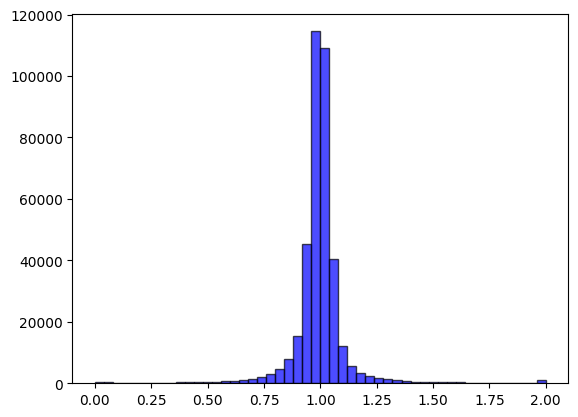

In [161]:
plt.hist(propensity_weights.flatten(), bins=50, alpha=0.7, color='blue', edgecolor='black')

## MC dropout test

In [101]:
import tensorflow_probability as tfp

In [117]:
def model_predict(model, dataset, config, mc_sampling=False):
    # Initialize lists to store final statistics for all chunks
    Predictions = []
    logs = 'Predicting ' + model.name
    if mc_sampling:
        pred_times = 10
    else:
        pred_times = 1

    for _ in range(pred_times):
        predictions = []
        for data_chunk in tqdm(dataset, desc=logs):
            batch_size = tf.shape(data_chunk['inputs'])[0]
            hidden_layer_size = config[2]
            initial_state = tf.zeros([batch_size, hidden_layer_size], dtype=tf.float32)
            # Predict the current chunk multiple times
            chunk_prediction, _, _ = model.predict([data_chunk['inputs'], initial_state, initial_state], verbose=0)
            # print(prediction.shape)
                # chunk_predictions.append(prediction)

            # Convert list of predictions to a numpy array for statistical computation
            # chunk_predictions = np.array(chunk_predictions)
            predictions.extend(chunk_prediction)
        
        if mc_sampling:
            Predictions.append(predictions)
    
    if mc_sampling:
        return np.stack(Predictions,axis=0)
    else:
        return np.array(predictions)

In [40]:
# load model
config_actions = configs['action_num']
model_folder = os.path.join(MODEL_ROOT, config_actions[0])
model_action = rmsn_model.load_model(model_folder, config_actions[-1])

config_treats = configs['action_den']
model_folder = os.path.join(MODEL_ROOT, config_treats[0])
model_treats = rmsn_model.load_model(model_folder, config_treats[-1])

In [98]:
results = model_predict(model_treats, tf_data_test, config_treats, mc_sampling=True)

Predicting treatment_rnn: 100%|██████████| 5/5 [00:00<00:00, 13.00it/s]


In [115]:
num_continuous = 1
continuous_preds, _ = np.split(results, [num_continuous], axis=-1)
continuous_preds.shape

(10, 300, 160, 1)

In [48]:
output_size=3; mc_size=1
pred = predict_with_mc_dropout(model_treats, tf_data_test, n_predictions=1)
pred.shape

Predicting treatment_rnn:   0%|          | 0/5 [00:00<?, ?it/s]


ValueError: No such layer: lstm. Existing layers are: ['input_2', 'initial_h', 'initial_c', 'lstm_1', 'dense_2', 'reshape_1', 'tf.split_1', 'dense_3', 'dropout_1', 'activation_1', 'concatenate_1'].

In [81]:
def predict_with_mc_dropout(model, dataset, n_predictions=10):
    Predictions = []
    for _ in range(n_predictions):
        preds = model_predict(model, tf_data_test, config_treats)
        preds = preds['mean_pred']
        continuous_preds,_ = tf.split(preds, [mc_size, output_size - mc_size], axis=-1)
        Predictions.append(continuous_preds)
    
    return tf.stack(Predictions,axis=0)

In [82]:
predictions = predict_with_mc_dropout(model_treats, tf_data_test)

Predicting treatment_rnn: 100%|██████████| 5/5 [00:00<00:00, 13.73it/s]


In [83]:
predictions.shape

TensorShape([10, 300, 160, 1])

In [111]:
# 为每个时间点建立分布
mean_predictions = tf.reduce_mean(predictions, axis=0)
std_dev_predictions = tf.math.reduce_std(predictions, axis=0)

distributions = tfp.distributions.Normal(loc=mean_predictions, scale=std_dev_predictions)

outputs = test_processed['outputs'][...,:1]
probs = distributions.prob(outputs)
probs = probs.numpy()

In [112]:
probs.shape

(300, 160, 3)

# dataset check

In [4]:
from utils.evaluation_utils import load_data

In [5]:
origin_data_path = "../fullfeature_fillmean_1000.txt"
origin_data = load_data(origin_data_path)

process_data_path = "results/tf2_test_dataset_with_substitute_confounders.h5"
process_data = load_data(process_data_path)

In [6]:
for key in origin_data.keys():
    print(key)
    print(origin_data[key].shape)
    print(origin_data[key].dtype)
print("\n")
for key in process_data.keys():
    print(key)
    print(process_data[key].shape)
    print(process_data[key].dtype)

previous_covariates
(3000, 160, 25)
float64
previous_treatments
(3000, 160, 3)
float64
covariates
(3000, 161, 25)
float64
treatments
(3000, 161, 3)
float64
sequence_length
(3000,)
int64
outcomes
(3000, 161, 1)
float64


covariates
(3000, 161, 25)
float32
outcomes
(3000, 161, 1)
float32
predicted_confounders
(3000, 161, 1)
float32
previous_covariates
(3000, 160, 25)
float32
previous_treatments
(3000, 160, 3)
float32
sequence_length
(3000,)
int64
treatments
(3000, 161, 3)
float32


In [16]:
for key in process_data.keys():
    print(key)
    print(np.any(np.isnan(process_data[key])))
    # print(process_data[key].dtype)

covariates
False
outcomes
False
predicted_confounders
False
previous_covariates
False
previous_treatments
False
sequence_length
False
treatments
False


In [14]:
for key in origin_data.keys():
    print(f"{key}:{np.all(origin_data[key]==process_data[key])}")

previous_covariates:False
previous_treatments:True
covariates:False
treatments:True
sequence_length:True
outcomes:True


In [22]:
key = "previous_covariates"
idx = np.where(origin_data[key]!=process_data[key])
print(origin_data[key][idx])
print(process_data[key][idx])

[13.2 17.2  0.1 ... 29.3  6.3 29.9]
[13.2 17.2  0.1 ... 29.3  6.3 29.9]


In [12]:
from rmsn.libs.data_process import data_generator, convert_to_tf_dataset_via_generator

In [13]:
gen = data_generator(training_processed, 256)  # 使用您的数据和批次大小
for data in gen():
    print(data)  # 打印看看是否产生了数据
    break  # 只查看第一批数据
# training_processed

{'inputs': array([[[ 1.        , -0.17024788, -0.02530078, ...,  0.11512377,
          0.        ,  0.        ],
        [ 1.        , -0.17024788, -0.02530078, ..., -1.2720935 ,
          0.        ,  0.        ],
        [ 1.        , -0.17024788, -0.02530078, ..., -1.3413386 ,
          0.        ,  0.        ],
        ...,
        [ 1.        , -0.17024788, -0.02530078, ..., -1.1035076 ,
          0.        ,  0.        ],
        [ 1.        , -0.17024788, -0.02530078, ...,  1.1884362 ,
          0.        ,  0.        ],
        [ 1.        , -0.17024788, -0.02530078, ..., -1.5693371 ,
          0.        ,  0.        ]],

       [[ 0.        , -0.17024788,  1.4222689 , ...,  0.64105654,
          0.        ,  0.        ],
        [ 0.        , -0.17024788,  1.4222689 , ...,  1.5331987 ,
          0.        ,  0.        ],
        [ 0.        , -0.17024788,  1.4222689 , ...,  1.933745  ,
          0.        ,  0.        ],
        ...,
        [ 0.        , -0.17024788,  1.42226

In [14]:
tf_data_train = convert_to_tf_dataset_via_generator(training_processed, 256)
for data in tf_data_train.take(1):  # 只取一个批次
    print(data)  # 检查数据内容

{'inputs': <tf.Tensor: shape=(256, 160, 28), dtype=float32, numpy=
array([[[ 0.        , -0.17024788,  1.4222689 , ..., -2.303025  ,
          0.        ,  0.        ],
        [ 0.        , -0.17024788,  1.4222689 , ..., -1.2382128 ,
          0.        ,  0.        ],
        [ 0.        , -0.17024788,  1.4222689 , ..., -0.80969423,
          0.        ,  0.        ],
        ...,
        [ 0.        , -0.17024788,  1.4222689 , ...,  0.11241431,
          0.        ,  0.        ],
        [ 0.        , -0.17024788,  1.4222689 , ...,  0.11241431,
          0.        ,  0.        ],
        [ 0.        , -0.17024788,  1.4222689 , ...,  0.11241431,
          0.        ,  0.        ]],

       [[ 1.        , -0.17024788,  0.698484  , ...,  1.0822569 ,
          0.        ,  0.        ],
        [ 1.        , -0.17024788,  0.698484  , ...,  0.8367583 ,
          0.        ,  0.        ],
        [ 1.        , -0.17024788,  0.698484  , ...,  0.17161907,
          0.        ,  0.        ],


2024-03-14 22:33:40.316081: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22288 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:03:00.0, compute capability: 8.9
2024-03-14 22:33:40.316777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22288 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:41:00.0, compute capability: 8.9


In [47]:
b_predict_actions = True
b_use_actions_only = True
training_processed = get_processed_data(training_data, b_predict_actions, b_use_actions_only,
                                                 b_use_predicted_confounders, b_use_oracle_confounders, b_remove_x1)

In [53]:
def _get_quantiles(data, bins):
   
    if not isinstance(bins, (int, np.integer)):
        raise ValueError(
            "Expected integer 'bins', but got type '{}'.".format(type(bins))
        )
    quantiles = np.unique(
        np.quantile(
            data, np.linspace(0, 1, bins + 1), interpolation="lower"
        )
    )
    bins = len(quantiles) - 1
    return quantiles, bins

In [49]:
training_processed['scaled_outputs'][:,:,0]

array([[ 5.,  5.,  5., ..., 10.,  5.,  5.],
       [11., 12., 12., ...,  8.,  8.,  8.],
       [ 6.,  6.,  6., ...,  7.,  7.,  7.],
       ...,
       [ 8.,  8., 12., ...,  5.,  5.,  5.],
       [12., 11.,  8., ..., 10., 10., 10.],
       [ 6.,  4.,  6., ...,  8.,  8.,  8.]], dtype=float32)

In [54]:
quantiles, bins = _get_quantiles(training_processed['scaled_outputs'][:,:,0], 20)

/tmp/ipykernel_9164/2899687007.py:8: DeprecationWarning: the `interpolation=` argument to quantile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  np.quantile(


In [55]:
quantiles

array([ 0.,  5.,  6.,  7.,  8.,  9., 10., 11., 19.], dtype=float32)